# Lung Cancer CT Scan Dataset

# Dataset Description:
This dataset contains CT scan images for lung cancer detection and classification. It includes images of four different categories: adenocarcinoma, large cell carcinoma, squamous cell carcinoma, and normal (non-cancerous) lung tissue.

# Classes:
1. Adenocarcinoma2. 
Large Cell Carcinoma3. 
Normal (non-cancerous4. )
Squamous Cell Carcin

   # LinkedIn Profile: https://www.linkedin.com/in/yadidya-medepalli/

   # Github Profile: https://github.com/YadidyaM
   oma

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

In [2]:
train_dir = "C:\\Users\\medep\\Downloads\\archive (6)\\train"
valid_dir = "C:\\Users\\medep\\Downloads\\archive (6)\\valid"
test_dir = "C:\\Users\\medep\\Downloads\\archive (6)\\test"

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   shear_range=0.3,
                                   zoom_range=0.3,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=True)
valid_generator = valid_datagen.flow_from_directory(valid_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=32, class_mode='categorical', shuffle=False)


Found 612 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


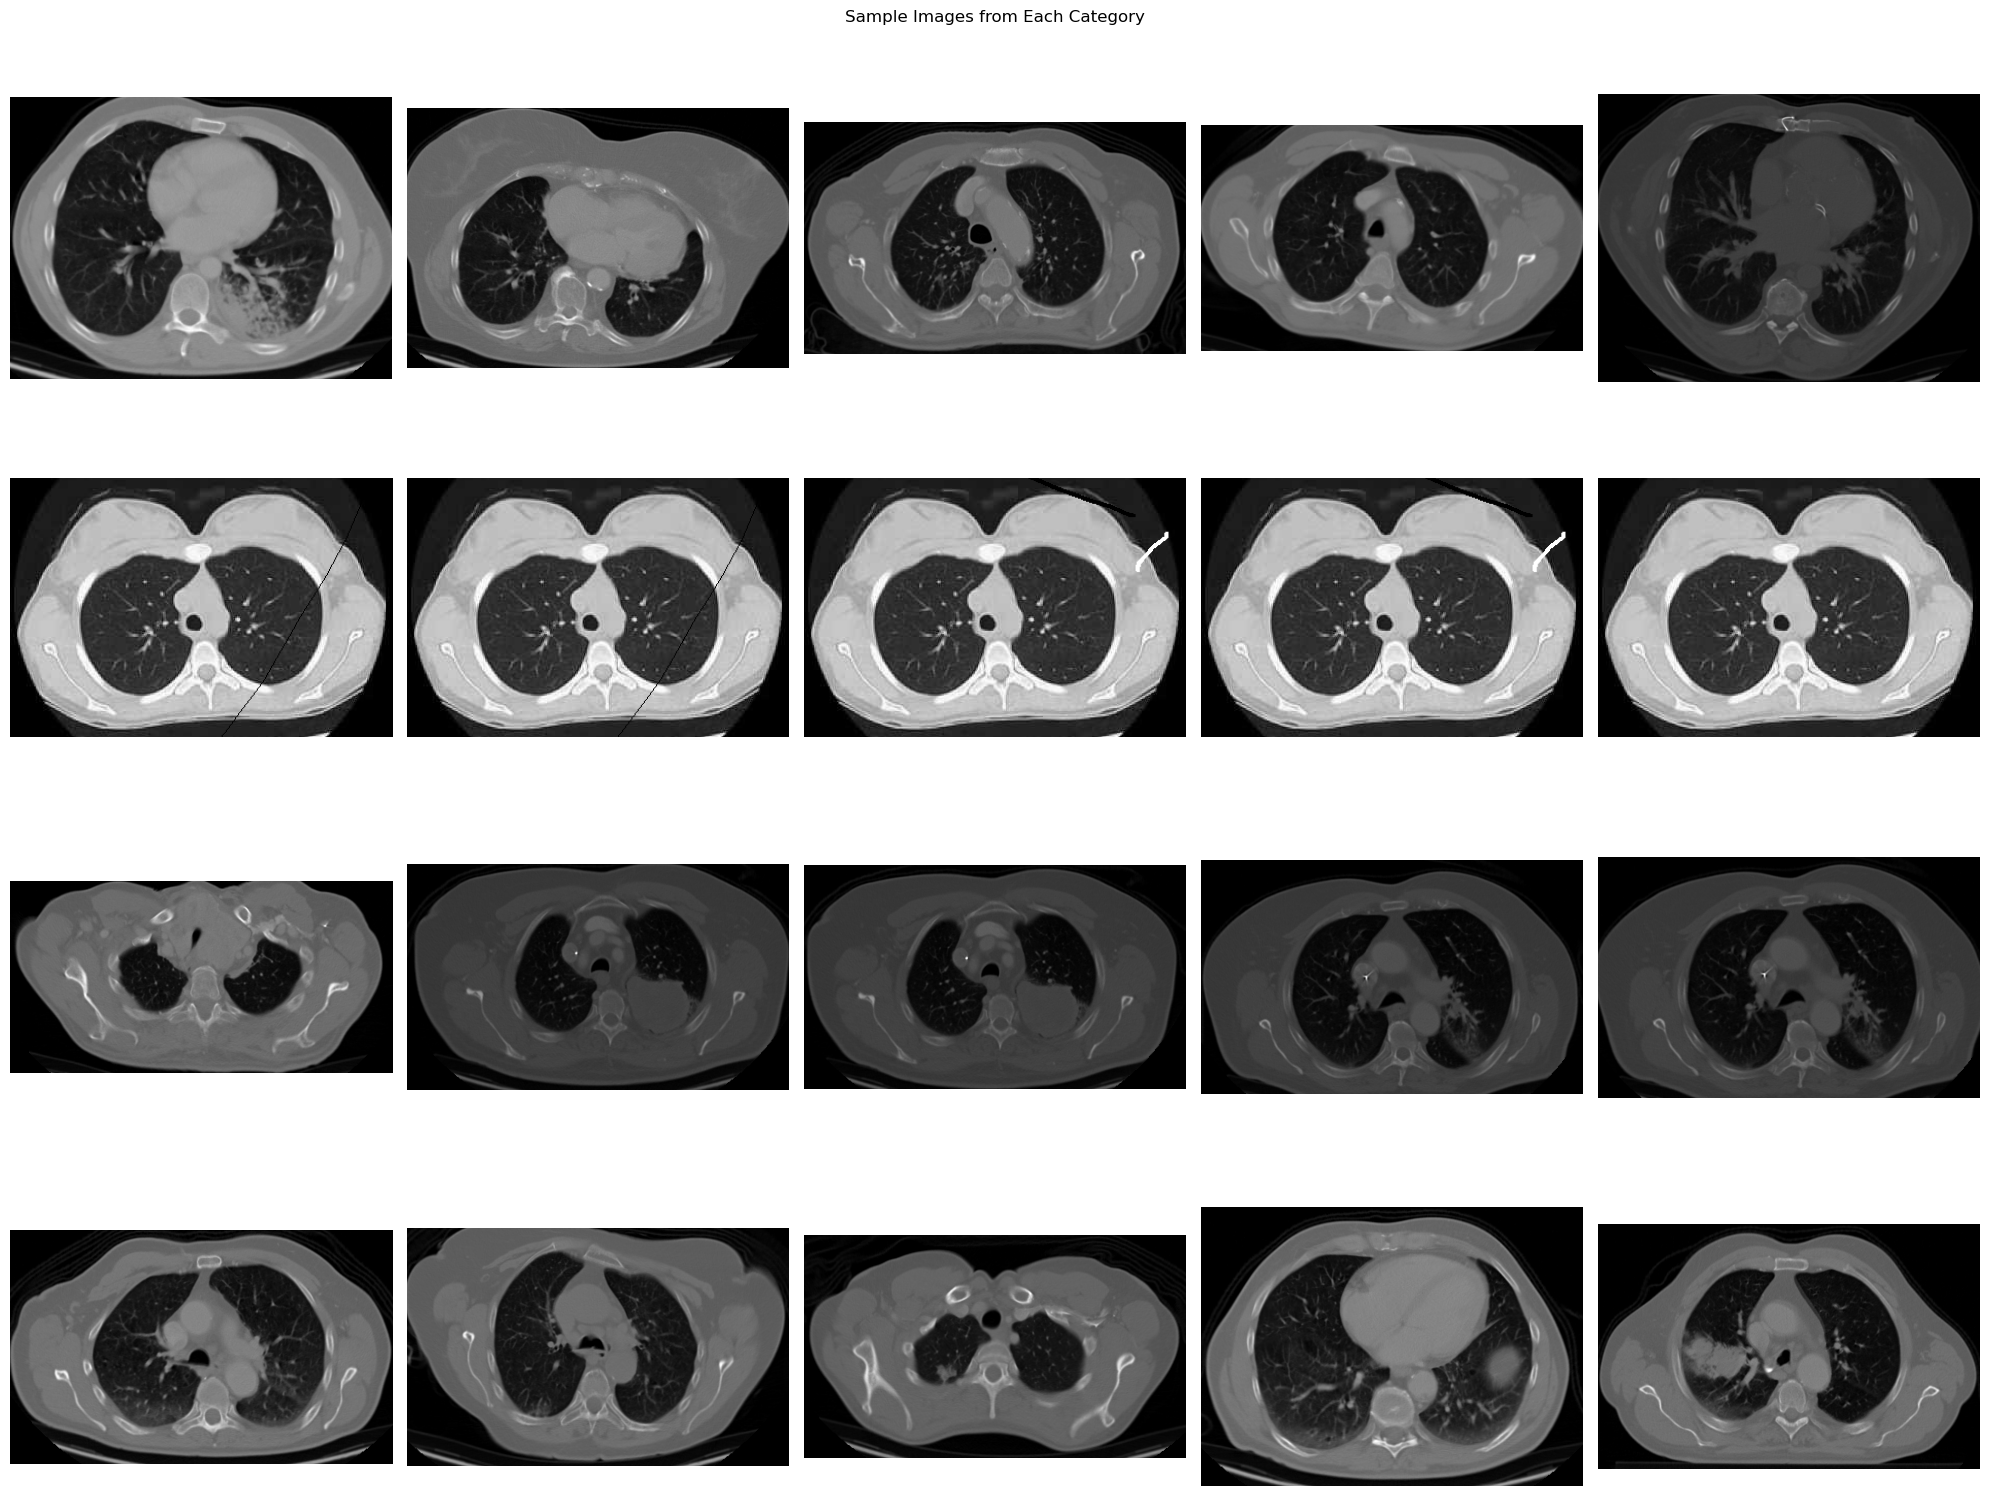

In [32]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import seaborn as sns

# Paths to the directories
directories = {
    "Squamous Cell Carcinoma": "C:\\Users\\medep\\Downloads\\archive (6)\\train\\squamous.cell.carcinoma_left.hilum_T1_N2_M0_IIIa",
    "Normal": "C:\\Users\\medep\\Downloads\\archive (6)\\train\\normal",
    "Large Cell Carcinoma": "C:\\Users\\medep\\Downloads\\archive (6)\\train\\large.cell.carcinoma_left.hilum_T2_N2_M0_IIIa",
    "Adenocarcinoma": "C:\\Users\\medep\\Downloads\\archive (6)\\train\\adenocarcinoma_left.lower.lobe_T2_N0_M0_Ib"
}

# Function to load images from a directory
def load_images_from_dir(directory, num_images=5):
    images = []
    for filename in os.listdir(directory)[:num_images]:
        img_path = os.path.join(directory, filename)
        img = Image.open(img_path)
        images.append(img)
    return images

# Visualization 1: Display a sample of images from each category
fig, axes = plt.subplots(len(directories), 5, figsize=(20, 4*len(directories)))
fig.suptitle('Sample Images from Each Category')

for i, (label, directory) in enumerate(directories.items()):
    images = load_images_from_dir(directory)
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
    axes[i, 0].set_ylabel(label, size='large')

plt.tight_layout()
plt.show()


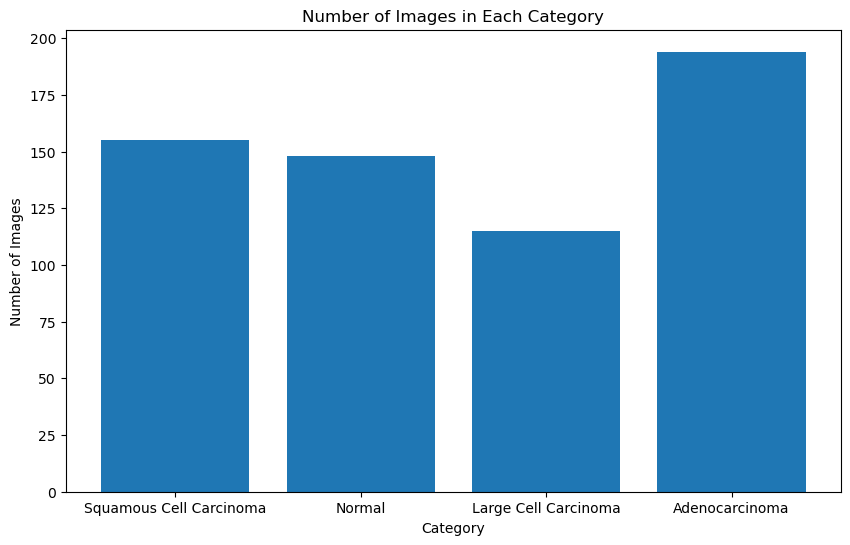

In [33]:
# Visualization 2: Count of images in each category
counts = {label: len(os.listdir(directory)) for label, directory in directories.items()}
plt.figure(figsize=(10, 6))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Category')
plt.show()

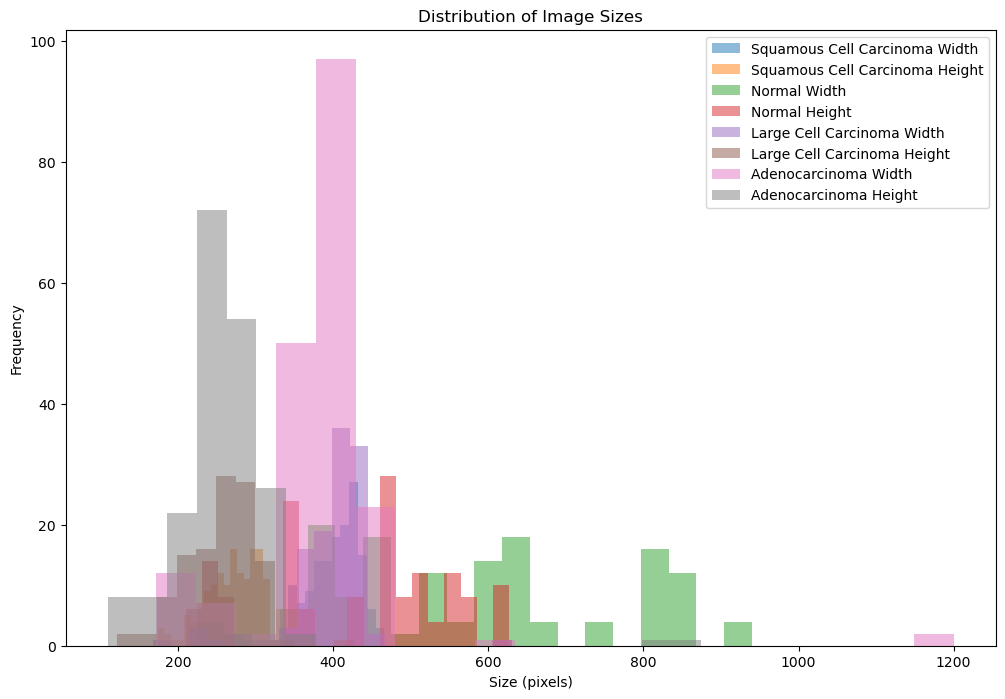

In [34]:
# Visualization 3: Image size distribution
image_sizes = {label: [] for label in directories}

for label, directory in directories.items():
    for filename in os.listdir(directory):
        img_path = os.path.join(directory, filename)
        with Image.open(img_path) as img:
            image_sizes[label].append(img.size)

plt.figure(figsize=(12, 8))
for label, sizes in image_sizes.items():
    width, height = zip(*sizes)
    plt.hist(width, alpha=0.5, label=f'{label} Width', bins=20)
    plt.hist(height, alpha=0.5, label=f'{label} Height', bins=20)

plt.xlabel('Size (pixels)')
plt.ylabel('Frequency')
plt.title('Distribution of Image Sizes')
plt.legend(loc='upper right')
plt.show()

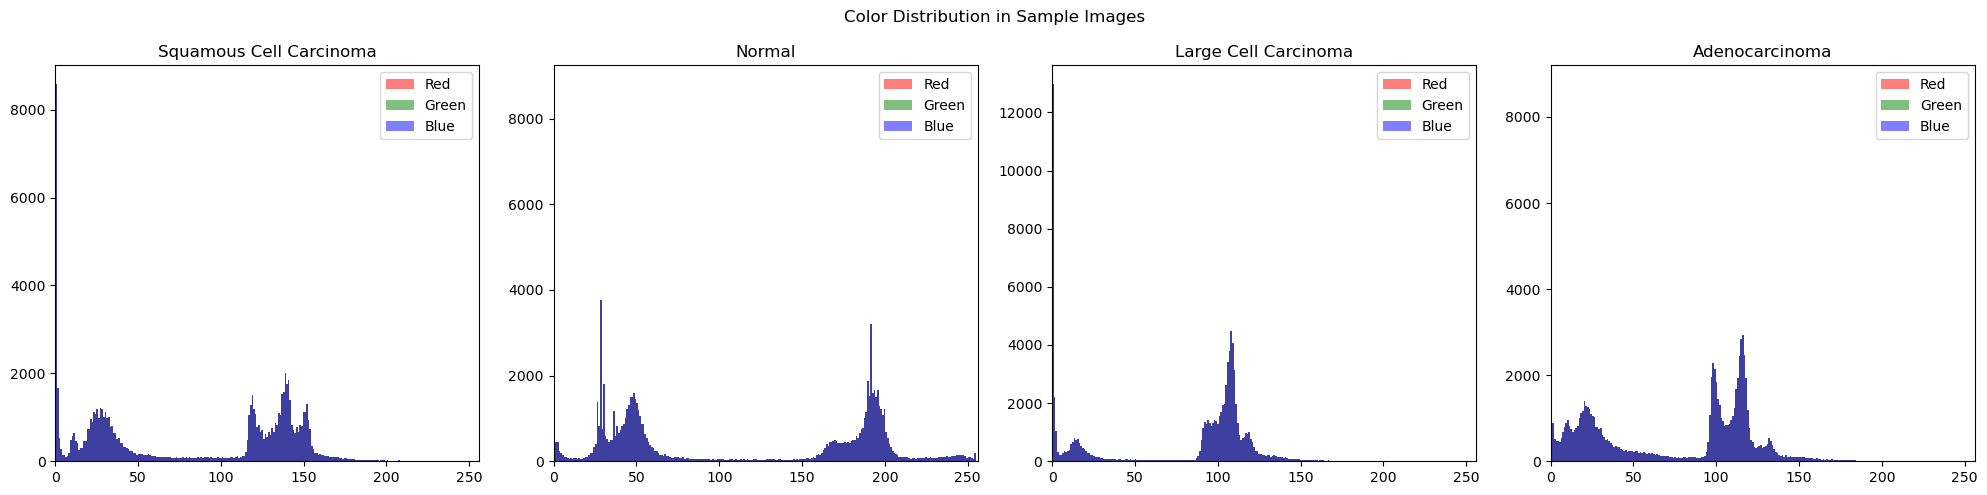

In [35]:

# Visualization 4: Color distribution in images
def plot_color_distribution(image, ax, title):
    arr = np.array(image)
    r, g, b = arr[:, :, 0].flatten(), arr[:, :, 1].flatten(), arr[:, :, 2].flatten()
    ax.hist(r, bins=256, color='red', alpha=0.5, label='Red')
    ax.hist(g, bins=256, color='green', alpha=0.5, label='Green')
    ax.hist(b, bins=256, color='blue', alpha=0.5, label='Blue')
    ax.set_xlim(0, 256)
    ax.set_title(title)
    ax.legend()

fig, axes = plt.subplots(1, len(directories), figsize=(20, 5))
fig.suptitle('Color Distribution in Sample Images')

for ax, (label, directory) in zip(axes, directories.items()):
    sample_image = load_images_from_dir(directory, num_images=1)[0]
    plot_color_distribution(sample_image, ax, label)

plt.tight_layout()
plt.show()


In [4]:
def extract_features(generator, num_images):
    vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))
    steps = int(np.ceil(num_images / generator.batch_size))
    features = vgg_model.predict(generator, steps=steps)
    return features.reshape(features.shape[0], -1)

train_features = extract_features(train_generator, train_generator.samples)
valid_features = extract_features(valid_generator, valid_generator.samples)
test_features = extract_features(test_generator, test_generator.samples)


C:\Users\medep\Downloads\Navigator\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step


In [5]:
train_labels = train_generator.classes
valid_labels = valid_generator.classes
test_labels = test_generator.classes

In [6]:
def xgb_objective(params):
    xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', **params)
    xgb_model.fit(train_features, train_labels)
    preds = xgb_model.predict(valid_features)
    accuracy = accuracy_score(valid_labels, preds)
    return {'loss': -accuracy, 'status': STATUS_OK}

In [7]:
xgb_space = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'max_depth': hp.choice('max_depth', np.arange(3, 10, dtype=int)),
    'n_estimators': hp.choice('n_estimators', np.arange(50, 300, step=50, dtype=int)),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'subsample': hp.uniform('subsample', 0.6, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.6, 1.0)
}

In [8]:
xgb_trials = Trials()
xgb_best = fmin(fn=xgb_objective, space=xgb_space, algo=tpe.suggest, max_evals=20, trials=xgb_trials)


100%|██████████████████████████████████████████████| 20/20 [54:39<00:00, 163.98s/trial, best loss: -0.3055555555555556]


In [9]:
best_xgb_model = xgb.XGBClassifier(objective='multi:softprob', num_class=4, eval_metric='mlogloss', **xgb_best)
best_xgb_model.fit(train_features, train_labels)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9363500124738781, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None,
              gamma=0.18287767450167902, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.15900792181449652,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=4, n_jobs=None, num_class=4,
              num_parallel_tree=None, ...)

In [10]:
xgb_preds = best_xgb_model.predict(test_features)
xgb_accuracy = accuracy_score(test_labels, xgb_preds)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.2f}")

XGBoost Test Accuracy: 0.29


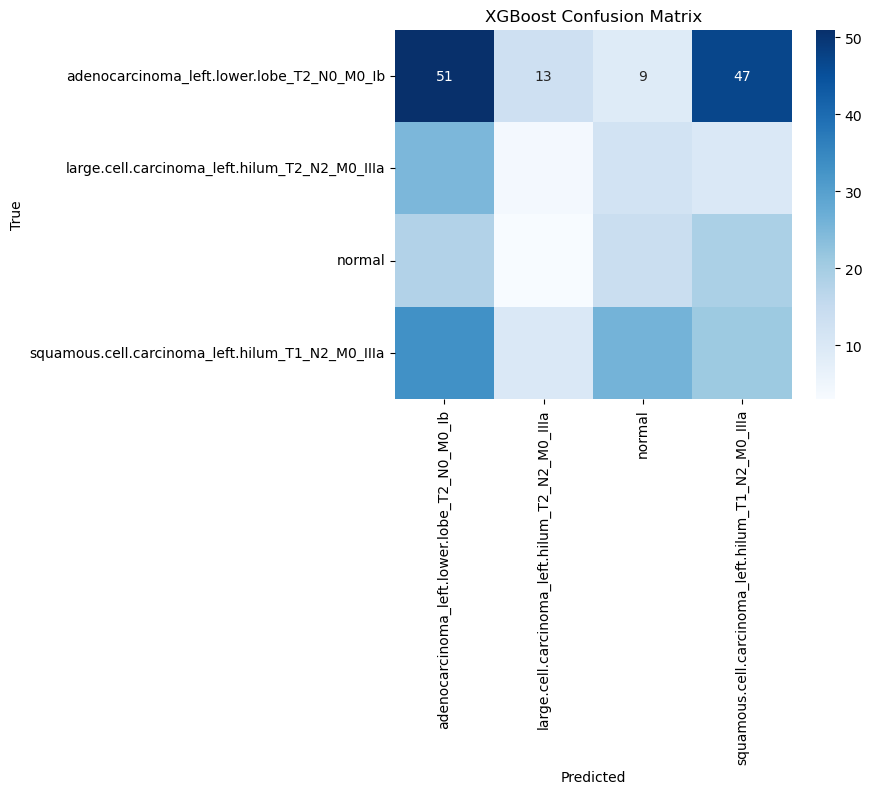

In [11]:
xgb_cm = confusion_matrix(test_labels, xgb_preds)
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [12]:
def create_cnn_model(learning_rate, dropout_rate):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [13]:
def cnn_objective(params):
    model = create_cnn_model(params['learning_rate'], params['dropout_rate'])
    history = model.fit(train_generator, validation_data=valid_generator, epochs=10, verbose=0)
    val_accuracy = np.mean(history.history['val_accuracy'])
    return {'loss': -val_accuracy, 'status': STATUS_OK}

In [23]:
cnn_space = {
    'learning_rate': hp.uniform('learning_rate', 0.0001, 0.01),
    'dropout_rate': hp.uniform('dropout_rate', 0.3, 0.7)
}

In [24]:
cnn_trials = Trials()
cnn_best = fmin(fn=cnn_objective, space=cnn_space, algo=tpe.suggest, max_evals=20, trials=cnn_trials)


  0%|                                                                           | 0/20 [00:00<?, ?trial/s, best loss=?]

C:\Users\medep\Downloads\Navigator\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



100%|███████████████████████████████████████████| 20/20 [1:02:44<00:00, 188.24s/trial, best loss: -0.47361111342906953]


In [25]:
best_cnn_model = create_cnn_model(cnn_best['learning_rate'], cnn_best['dropout_rate'])
cnn_history = best_cnn_model.fit(train_generator, validation_data=valid_generator, epochs=20)


Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 643ms/step - accuracy: 0.2740 - loss: 6.4052 - val_accuracy: 0.3889 - val_loss: 1.3044
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 643ms/step - accuracy: 0.4245 - loss: 1.2119 - val_accuracy: 0.2222 - val_loss: 1.4953
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 633ms/step - accuracy: 0.4115 - loss: 1.2667 - val_accuracy: 0.3889 - val_loss: 1.1498
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 625ms/step - accuracy: 0.4370 - loss: 1.1443 - val_accuracy: 0.4861 - val_loss: 1.0345
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 623ms/step - accuracy: 0.4700 - loss: 1.1371 - val_accuracy: 0.5139 - val_loss: 1.0018
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 656ms/step - accuracy: 0.4776 - loss: 1.1310 - val_accuracy: 0.5417 - val_loss: 0.9758
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 650ms/step - accuracy: 0.5324 - loss: 0.9806 - val_accuracy: 0.5000 - val_loss: 0.9807
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 622ms/step - accuracy: 0.5243 - loss: 0.9899 - val_accu

In [26]:
cnn_loss, cnn_acc = best_cnn_model.evaluate(test_generator)
print(f"CNN Test Accuracy: {cnn_acc:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - accuracy: 0.7196 - loss: 0.8307
CNN Test Accuracy: 0.53


10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step


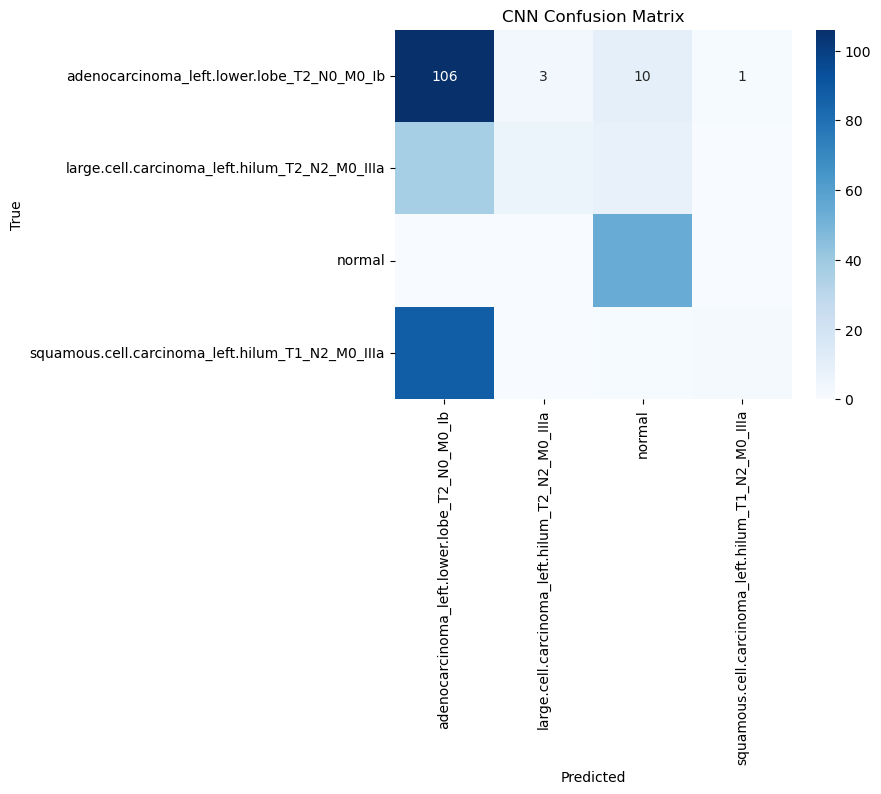

In [27]:
cnn_preds = np.argmax(best_cnn_model.predict(test_generator), axis=1)
cnn_cm = confusion_matrix(test_labels, cnn_preds)
sns.heatmap(cnn_cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('CNN Confusion Matrix')
plt.show()

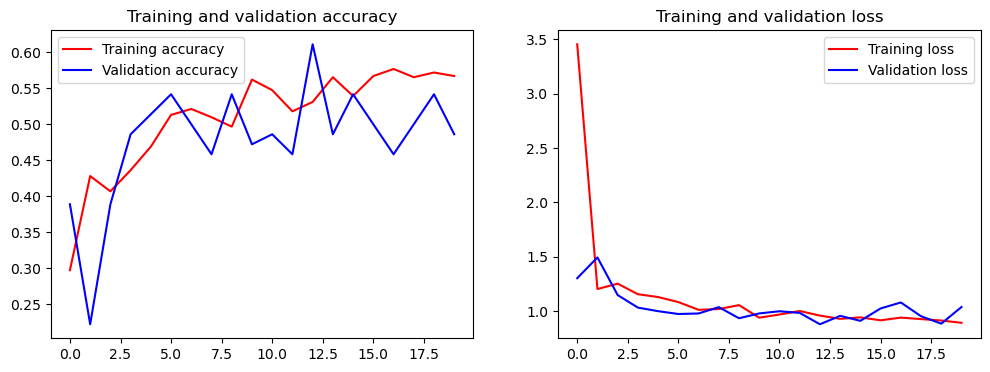

In [28]:
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_training_history(cnn_history)